# Download and process SRA data

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

import os
import rpy2
from pathlib import Path
import pandas as pd
from core_acc_modules import utils

import umap
from plotnine import (ggplot,
                      labs,  
                      geom_point,
                      aes, 
                      ggsave,
                      theme,
                      theme_bw,
                      scale_color_manual,
                      guides, 
                      guide_legend,
                      element_blank,
                      element_text,
                      element_rect,
                      element_line,
                      coords)

In [2]:
%%R
# Select 59
# Run one time
#if (!requireNamespace("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")
#BiocManager::install("tximport")

NULL


### Setup SRA toolkit

In [3]:
# Download latest version of compiled binaries of NCBI SRA toolkit 
#if not os.path.exists("sratoolkit.current-centos_linux64.tar.gz"):
#    ! wget "ftp://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/current/sratoolkit.current-centos_linux64.tar.gz"

In [4]:
# Extract tar.gz file 
#if not os.path.exists("sratoolkit.current-centos_linux64.tar.gz"):
#    ! tar -xzf sratoolkit.current-centos_linux64.tar.gz

# add binaries to path using export path or editing ~/.bashrc file
#! export PATH=$PATH:/home/alexandra/Documents/Data/Core_accessory/sratoolkit.2.10.7-centos_linux64/bin

# Now SRA binaries added to path and ready to use

### Download SRA data

Two SRA projects were selected:
* [PRJNA633671](https://www.ncbi.nlm.nih.gov/bioproject/PRJNA633671) 13 PAO1 samples isolated from pig burn wound after 3 (3), 14(5), 28(5) days post infection
* [PRJNA491911](https://www.ncbi.nlm.nih.gov/bioproject/PRJNA491911) 15 PA14 samples isolated from pig burn wound after 3 (5), 14 (5), 28 (5) days post infection

In [5]:
# Download sra data files
! prefetch --option-file data/metadata/sra_acc.txt 


2020-07-07T17:03:35 prefetch.2.8.2: 1) 'SRR11809598' is found locally
2020-07-07T17:03:35 prefetch.2.8.2: 'SRR11809598' has 0 unresolved dependencies

2020-07-07T17:03:36 prefetch.2.8.2: 2) 'SRR11809599' is found locally
2020-07-07T17:03:36 prefetch.2.8.2: 'SRR11809599' has 0 unresolved dependencies

2020-07-07T17:03:36 prefetch.2.8.2: 3) 'SRR11809600' is found locally
2020-07-07T17:03:36 prefetch.2.8.2: 'SRR11809600' has 0 unresolved dependencies

2020-07-07T17:03:36 prefetch.2.8.2: 4) 'SRR11809601' is found locally
2020-07-07T17:03:37 prefetch.2.8.2: 'SRR11809601' has 0 unresolved dependencies

2020-07-07T17:03:37 prefetch.2.8.2: 5) 'SRR11809602' is found locally
2020-07-07T17:03:37 prefetch.2.8.2: 'SRR11809602' has 0 unresolved dependencies

2020-07-07T17:03:37 prefetch.2.8.2: 6) 'SRR11809603' is found locally
2020-07-07T17:03:37 prefetch.2.8.2: 'SRR11809603' has 0 unresolved dependencies

2020-07-07T17:03:38 prefetch.2.8.2: 7) 'SRR11809604' is found locally
2020-07-07T17:03:38 pre

### Get FASTQ files associated with SRA downloads

The fastq files store the RNA-seq results, including: sequencing and quality scores for each base call.

Here is a nice blog to explain how to read fastq files: https://thesequencingcenter.com/knowledge-base/fastq-files/

The fastq files gives the sequence of a read at a given location. Our goal is to map these reads to a reference genome so that we can quantify the number of reads that are at a given location, to determine the level of expression.

In [6]:
#! fastq-dump ~/ncbi/public/sra/* --split-files --outdir ~/ncbi/public/fastq/

### Obtain a transcriptome and build an index

Here we are using [Salmon](https://combine-lab.github.io/salmon/)

**Input:**
* Target transcriptome
* This transcriptome is given to Salmon in the form of a (possibly compressed) multi-FASTA file, with each entry providing the sequence of a transcript
* DNA sequences (genes) that get transcribed as mRNA (transcripts). Should we look at reference transcipts or genes?
* We downloaded the `GENE DNA` file for `Pseudomonas aeruginosa PAO1 (Reference)` and `Pseudomonas aeruginosa UCBPP-PA14` from  http://www.pseudomonas.com/strain/download

**Output:**
* The index is a structure that salmon uses to quasi-map RNA-seq reads during quantification
* [Quasi-map](https://academic.oup.com/bioinformatics/article/32/12/i192/2288985) is a way to map sequenced fragments (single or paired-end reads) to a target transcriptome. Quasi-mapping produces what we refer to as fragment mapping information. In particular, it provides, for each query (fragment), the reference sequences (transcripts), strand and position from which the query may have likely originated. In many cases, this mapping information is sufficient for downstream analysis like quantification.

*Algorithm:*

For a query read r through repeated application of: 
1. Determining the next hash table k-mer that starts past the current query position
2. Computing the maximum mappable prefix (MMP) of the query beginning with this k-mer
3. Determining the next informative position (NIP) by performing a longest common prefix (LCP) query on two specifically chosen suffixes in the SA

In [7]:
# Get PAO1 index
! salmon index -t ~/Documents/Data/Core_accessory/Pseudomonas_aeruginosa_PAO1_107.ffn.gz -i ~/Documents/Data/Core_accessory/pao1_index

Version Info: This is the most recent version of salmon.
index ["/home/alexandra/Documents/Data/Core_accessory/pao1_index"] did not previously exist  . . . creating it
[2020-07-07 13:03:46.058] [jLog] [warning] The salmon index is being built without any decoy sequences.  It is recommended that decoy sequence (either computed auxiliary decoy sequence or the genome of the organism) be provided during indexing. Further details can be found at https://salmon.readthedocs.io/en/latest/salmon.html#preparing-transcriptome-indices-mapping-based-mode.
[2020-07-07 13:03:46.058] [jLog] [info] building index
out : /home/alexandra/Documents/Data/Core_accessory/pao1_index
[2020-07-07 13:03:46.058] [puff::index::jointLog] [info] Running fixFasta

[Step 1 of 4] : counting k-mers

[2020-07-07 13:03:46.225] [puff::index::jointLog] [warning] Removed 34 transcripts that were sequence duplicates of indexed transcripts.
[2020-07-07 13:03:46.225] [puff::index::jointLog] [warning] If you wish to retain duplic

In [8]:
# Get PA14 index
! salmon index -t ~/Documents/Data/Core_accessory/Pseudomonas_aeruginosa_UCBPP-PA14_109.ffn.gz -i ~/Documents/Data/Core_accessory/pa14_index

Version Info: This is the most recent version of salmon.
index ["/home/alexandra/Documents/Data/Core_accessory/pa14_index"] did not previously exist  . . . creating it
[2020-07-07 13:03:49.172] [jLog] [warning] The salmon index is being built without any decoy sequences.  It is recommended that decoy sequence (either computed auxiliary decoy sequence or the genome of the organism) be provided during indexing. Further details can be found at https://salmon.readthedocs.io/en/latest/salmon.html#preparing-transcriptome-indices-mapping-based-mode.
[2020-07-07 13:03:49.172] [jLog] [info] building index
out : /home/alexandra/Documents/Data/Core_accessory/pa14_index
[2020-07-07 13:03:49.172] [puff::index::jointLog] [info] Running fixFasta

[Step 1 of 4] : counting k-mers

[2020-07-07 13:03:49.305] [puff::index::jointLog] [warning] Removed 37 transcripts that were sequence duplicates of indexed transcripts.
[2020-07-07 13:03:49.305] [puff::index::jointLog] [warning] If you wish to retain duplic

**!NOTE! Currently we're using genes NOT transcripts for our reference transcriptome. This may change in the future. Waiting to here back from Deb/Georgia** 

### Quantify gene expression
Now that we have our index built and all of our data downloaded, we’re ready to quantify our samples

**Input:**
* Index of reference transcriptome
* FASTQ of experimental samples

**Output:**

After the salmon commands finish running, you should have a directory named quants, which will have a sub-directory for each sample. These sub-directories contain the quantification results of salmon, as well as a lot of other information salmon records about the sample and the run. 

The main output file (called `quant.sf`). Inside the quantification file for sample DRR016125 in quants/DRR016125/quant.sf, you’ll see a TSV format file listing the name (`Name`) of each transcript, its length (`Length`), effective length (`EffectiveLength`), and its abundance in terms of Transcripts Per Million (`TPM`) and estimated number of reads (`NumReads`) originating from this transcript.

**For each sample we have read counts per gene (where the genes are based on the reference gene file provided above).** 

#### Get quants using PAO1 reference

In [9]:
%%bash
mkdir ~/ncbi/public/quants_pao1/

for FILE_PATH in ~/ncbi/public/fastq/*;
do

# get file name
sample_name=`basename ${FILE_PATH}`

# remove extension from file name
sample_name="${sample_name%_*}"

# get base path
base_name=${FILE_PATH%/*}

echo "Processing sample ${sample_name}"

salmon quant -i ~/Documents/Data/Core_accessory/pao1_index -l A \
            -1 ${base_name}/${sample_name}_1.fastq \
            -2 ${base_name}/${sample_name}_2.fastq \
            -p 8 --validateMappings -o ~/ncbi/public/quants_pao1/${sample_name}_quant
done

Processing sample SRR11809598
Processing sample SRR11809598
Processing sample SRR11809599
Processing sample SRR11809599
Processing sample SRR11809600
Processing sample SRR11809600
Processing sample SRR11809601
Processing sample SRR11809601
Processing sample SRR11809602
Processing sample SRR11809602
Processing sample SRR11809603
Processing sample SRR11809603
Processing sample SRR11809604
Processing sample SRR11809604
Processing sample SRR11809605
Processing sample SRR11809605
Processing sample SRR11809606
Processing sample SRR11809606
Processing sample SRR11809607
Processing sample SRR11809607
Processing sample SRR11809626
Processing sample SRR11809626
Processing sample SRR11809627
Processing sample SRR11809627
Processing sample SRR11809628
Processing sample SRR11809628
Processing sample SRR7886554
Processing sample SRR7886554
Processing sample SRR7886555
Processing sample SRR7886555
Processing sample SRR7886556
Processing sample SRR7886556
Processing sample SRR7886557
Processing sample

mkdir: cannot create directory ‘/home/alexandra/ncbi/public/quants_pao1/’: File exists
Version Info: This is the most recent version of salmon.
### salmon (selective-alignment-based) v1.3.0
### [ program ] => salmon 
### [ command ] => quant 
### [ index ] => { /home/alexandra/Documents/Data/Core_accessory/pao1_index }
### [ libType ] => { A }
### [ mates1 ] => { /home/alexandra/ncbi/public/fastq/SRR11809598_1.fastq }
### [ mates2 ] => { /home/alexandra/ncbi/public/fastq/SRR11809598_2.fastq }
### [ threads ] => { 8 }
### [ validateMappings ] => { }
### [ output ] => { /home/alexandra/ncbi/public/quants_pao1/SRR11809598_quant }
Logs will be written to /home/alexandra/ncbi/public/quants_pao1/SRR11809598_quant/logs
[2020-07-07 13:03:52.475] [jointLog] [info] setting maxHashResizeThreads to 8
[2020-07-07 13:03:52.475] [jointLog] [info] Fragment incompatibility prior below threshold.  Incompatible fragments will be ignored.
[2020-07-07 13:03:52.475] [jointLog] [info] Usage of --validateMapp

#### Get quants using PA14 reference

In [10]:
%%bash
mkdir ~/ncbi/public/quants_pa14/

for FILE_PATH in ~/ncbi/public/fastq/*;
do

# get file name
sample_name=`basename ${FILE_PATH}`

# remove extension from file name
sample_name="${sample_name%_*}"

# get base path
base_name=${FILE_PATH%/*}

echo "Processing sample ${sample_name}"

salmon quant -i ~/Documents/Data/Core_accessory/pa14_index -l A \
            -1 ${base_name}/${sample_name}_1.fastq \
            -2 ${base_name}/${sample_name}_2.fastq \
            -p 8 --validateMappings -o ~/ncbi/public/quants_pa14/${sample_name}_quant
done

Processing sample SRR11809598
Processing sample SRR11809598
Processing sample SRR11809599
Processing sample SRR11809599
Processing sample SRR11809600
Processing sample SRR11809600
Processing sample SRR11809601
Processing sample SRR11809601
Processing sample SRR11809602
Processing sample SRR11809602
Processing sample SRR11809603
Processing sample SRR11809603
Processing sample SRR11809604
Processing sample SRR11809604
Processing sample SRR11809605
Processing sample SRR11809605
Processing sample SRR11809606
Processing sample SRR11809606
Processing sample SRR11809607
Processing sample SRR11809607
Processing sample SRR11809626
Processing sample SRR11809626
Processing sample SRR11809627
Processing sample SRR11809627
Processing sample SRR11809628
Processing sample SRR11809628
Processing sample SRR7886554
Processing sample SRR7886554
Processing sample SRR7886555
Processing sample SRR7886555
Processing sample SRR7886556
Processing sample SRR7886556
Processing sample SRR7886557
Processing sample

mkdir: cannot create directory ‘/home/alexandra/ncbi/public/quants_pa14/’: File exists
Version Info: This is the most recent version of salmon.
### salmon (selective-alignment-based) v1.3.0
### [ program ] => salmon 
### [ command ] => quant 
### [ index ] => { /home/alexandra/Documents/Data/Core_accessory/pa14_index }
### [ libType ] => { A }
### [ mates1 ] => { /home/alexandra/ncbi/public/fastq/SRR11809598_1.fastq }
### [ mates2 ] => { /home/alexandra/ncbi/public/fastq/SRR11809598_2.fastq }
### [ threads ] => { 8 }
### [ validateMappings ] => { }
### [ output ] => { /home/alexandra/ncbi/public/quants_pa14/SRR11809598_quant }
Logs will be written to /home/alexandra/ncbi/public/quants_pa14/SRR11809598_quant/logs
[2020-07-07 13:11:12.219] [jointLog] [info] setting maxHashResizeThreads to 8
[2020-07-07 13:11:12.219] [jointLog] [info] Fragment incompatibility prior below threshold.  Incompatible fragments will be ignored.
[2020-07-07 13:11:12.219] [jointLog] [info] Usage of --validateMapp

### Map transcript-level abundances to genes

**!NOTE! Tximport maps transcripts to genes (if reference transcriptome uses transcripts). Since we're using genes instead of transcripts (for now) this step is redundant, we have added it as a placeholder.**

In [11]:
%%R
library(tximport)


Error in library(tximport) : there is no package called ‘tximport’


/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error in library(tximport) : there is no package called ‘tximport’

  warnings.warn(x, RRuntimeWarning)


In [12]:
%%R
# Get all files in quants/
#file <- "~/ncbi/public/quants/SRR7886554_quant/quant.sf"
#tx2gene is the mapping file
#txi.salmon <- tximport(file, type = "salmon", tx2gene = tx2gene)
#head(txi.salmon$counts)

# Output is of the form gene x sample, so this will be fairly straightforward to convert to dataframe

NULL


### Consolidate sample quantification to gene expression dataframe

In [13]:
# PAO1
# Read through all sample subdirectories in quant/
# Within each sample subdirectory, get quant.sf file
data_dir = Path("/home/alexandra/ncbi/public/quants_pao1/")

expression_pao1_df = pd.DataFrame(
    pd.read_csv(file, sep="\t", index_col=0)["TPM"].
    rename(file.parent.name.split("_")[0]) 
    for file in data_dir.rglob("*/quant.sf"))    

expression_pao1_df.head()

Name,PGD134012,PGD134018,PGD134020,PGD134022,PGD134024,PGD134014,PGD134016,PGD134026,PGD134030,PGD134032,...,PGD133904,PGD133906,PGD133902,PGD133898,PGD133900,PGD133894,PGD133896,PGD133892,PGD133884,PGD133886
SRR7886564,231.716697,190.738607,251.429904,244.578756,232.656793,338.765896,154.620009,135.310463,197.291717,208.645563,...,384.064437,160.417353,217.451733,156.876167,207.877201,401.502751,243.875972,242.993504,246.340252,2508.289794
SRR7886563,221.851100,206.220034,262.500474,236.215828,218.766036,277.171087,172.762026,131.648821,203.899585,195.420045,...,422.489623,186.064347,221.791885,169.892025,206.037560,364.586581,220.706419,222.127074,290.802875,1822.132618
SRR7886556,239.037609,214.715742,274.754002,234.906201,211.417707,330.989596,182.536447,151.792216,177.385354,214.445136,...,313.550189,203.413841,219.453194,122.107033,216.622068,356.404618,204.936487,236.922729,344.193884,842.077389
SRR7886554,207.556616,225.560693,225.270200,219.560555,187.818032,288.553086,170.665744,153.010431,178.956296,189.191000,...,310.693309,162.017329,226.699021,151.312523,188.414231,344.307975,230.658402,215.728333,231.611916,2805.594275
SRR11809604,260.595430,246.808035,266.247333,265.971914,221.257821,326.514414,168.114885,173.749719,222.394860,211.512121,...,407.504879,218.529737,230.029451,167.604390,229.048883,376.002841,245.817367,271.995049,330.492500,3024.846023


In [14]:
# PA14
data_dir = Path("/home/alexandra/ncbi/public/quants_pa14/")

expression_pa14_df = pd.DataFrame(
    pd.read_csv(file, sep="\t", index_col=0)["TPM"].
    rename(file.parent.name.split("_")[0]) 
    for file in data_dir.rglob("*/quant.sf"))    

expression_pa14_df.head()

Name,PGD1650835,PGD1650837,PGD1650839,PGD1650841,PGD1650843,PGD1650845,PGD1650847,PGD1650849,PGD1650851,PGD1650853,...,PGD1662756,PGD1662758,PGD1662760,PGD1662762,PGD1662764,PGD1662766,PGD1662768,PGD1662770,PGD1662772,PGD1662774
SRR7886564,192.785612,158.748837,214.663820,202.817591,191.214347,284.436564,128.600681,111.774243,169.524597,181.994027,...,206.316241,318.416687,137.675735,176.718799,128.936270,172.671263,325.048689,207.805721,203.672907,198.229796
SRR7886563,185.990430,176.446811,226.771329,199.520353,181.207293,239.865143,148.188056,112.662020,173.922345,171.614927,...,214.487003,349.088231,160.868699,179.759765,147.532664,173.589740,327.589690,190.277834,187.380031,233.771534
SRR7886556,206.753755,182.731052,239.198488,204.350889,177.185073,281.298103,156.854366,130.637749,157.585343,183.592426,...,184.615231,266.237897,176.684756,187.725676,108.811516,185.389274,340.071402,179.377600,204.741883,291.301393
SRR7886554,178.715509,195.407863,192.604001,189.715227,163.104746,247.902106,147.762163,131.745903,154.769878,166.683319,...,194.693693,275.857755,140.847401,185.966178,128.549164,161.740058,316.983150,199.483132,185.437945,196.144360
SRR11809604,267.150630,254.680425,268.610111,271.402127,230.731028,333.383835,172.368983,176.956049,226.507236,217.911731,...,282.844751,416.327216,217.889906,242.638782,166.915012,234.779404,360.352377,248.541267,279.069876,340.190664


In [15]:
# Map gene ids to gene names
pa14_fasta_file = '/home/alexandra/Documents/Data/Core_accessory/Pseudomonas_aeruginosa_UCBPP-PA14_109.ffn.gz'
pao1_fasta_file = '/home/alexandra/Documents/Data/Core_accessory/Pseudomonas_aeruginosa_PAO1_107.ffn.gz'

seq_id_to_gene_id_pao1 = utils.dict_gene_num_to_ids(pao1_fasta_file)
seq_id_to_gene_id_pa14 = utils.dict_gene_num_to_ids(pa14_fasta_file)

expression_pao1_df.rename(mapper=seq_id_to_gene_id_pao1, axis="columns", inplace=True)
expression_pa14_df.rename(mapper=seq_id_to_gene_id_pa14, axis="columns", inplace=True)

### Quick validation
Is the expression of PAO1-specific genes 0 in PA14 samples? And vice versa

In [16]:
# Load in gene annotation file
gene_annot_file = os.path.join(
        "data",
        "metadata",
        "selected_gene_annotations.txt")

core_genes, acc_genes = utils.get_core_acc_genes(gene_annot_file)

In [17]:
# Load in sample annotation file
sample_annot_file = os.path.join(
        "data",
        "metadata",
        "sample_groups.txt")

pao1_ids, pa14_ids = utils.get_sample_grps(sample_annot_file)

In [18]:
# Examine PA14 samples in PAO1-specific genes
expression_pao1_df.loc[pa14_ids,acc_genes]

Name,PA0053,PA0095,PA0100,PA0135,PA0187,PA0188,PA0202,PA0203,PA0204,PA0205,...,PA4690,PA4802,PA4812,PA5060,PA5086,PA5149,PA5253,PA5264,PA5265,PA5570
SRR7886554,0.0,134.838153,0.000000,284.395901,0.0,0.000000,0.0,0.0,0.0,1.662679,...,256.059188,0.0,182.347910,83.818116,757.775645,147.063251,79.860497,0.000000,0.000000,2805.594275
SRR7886555,0.0,156.569943,0.000000,580.909486,0.0,1.322716,0.0,0.0,0.0,0.000000,...,271.612595,0.0,183.553133,98.402433,663.877566,163.178681,90.051254,0.000000,0.000000,4039.547928
SRR7886556,0.0,165.560367,0.000000,879.374473,0.0,0.000000,0.0,0.0,0.0,0.000000,...,265.497041,0.0,184.535066,80.107990,659.626629,145.155314,80.849069,0.000000,0.000000,842.077389
SRR7886557,0.0,146.960145,0.000000,611.777836,0.0,0.000000,0.0,0.0,0.0,0.000000,...,274.424624,0.0,168.892556,80.937042,393.973696,176.803484,82.916779,0.000000,0.000000,662.846938
SRR7886559,0.0,160.926991,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,264.947290,0.0,189.590069,84.065656,488.053772,152.259326,76.981990,0.000000,0.000000,962.126248
SRR7886560,0.0,169.760426,0.000000,897.642319,0.0,0.000000,0.0,0.0,0.0,0.000000,...,277.210830,0.0,188.787092,60.949962,362.751761,159.285404,107.179109,0.000000,0.000000,1833.630567
SRR7886562,0.0,160.979546,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,309.477709,0.0,201.734546,87.253444,525.855696,164.924275,81.050635,0.000000,0.000000,1453.898670
SRR7886563,0.0,154.937053,0.914162,1376.777689,0.0,0.000000,0.0,0.0,0.0,0.000000,...,275.654459,0.0,176.803625,92.915461,740.797804,124.490241,84.946825,0.000000,0.000000,1822.132618
SRR7886564,0.0,146.547614,0.000000,503.234953,0.0,0.000000,0.0,0.0,0.0,0.000000,...,265.720861,0.0,178.979808,71.693895,878.714735,142.754034,70.652032,0.000000,0.000000,2508.289794
SRR7886565,0.0,136.370994,0.000000,700.817933,0.0,0.000000,0.0,0.0,0.0,0.000000,...,254.922990,0.0,175.852444,72.864259,803.846326,119.700472,92.657146,0.000000,0.000000,3143.162279


#### Visualize clustering of gene expression

In [19]:
# Embed expression data into low dimensional space
model = umap.UMAP(random_state=123).fit(expression_pao1_df)
pao1_encoded = model.transform(expression_pao1_df)

pao1_encoded_df = pd.DataFrame(data=pao1_encoded,
                               index=expression_pao1_df.index,
                               columns=['1','2'])

# Add label
pao1_encoded_df['genotype'] = 'PAO1'
pao1_encoded_df.loc[pa14_ids,'genotype'] = 'PA14'

pao1_encoded_df.head()

,1,2,genotype
SRR7886564,-2.513736,17.909554,PA14
SRR7886563,-0.801892,18.760143,PA14
SRR7886556,-0.742444,18.170839,PA14
SRR7886554,-2.093919,17.483015,PA14
SRR11809604,-2.423168,8.662819,PAO1


In [20]:
# Embed expression data into low dimensional space
model = umap.UMAP(random_state=123).fit(expression_pa14_df)
pa14_encoded = model.transform(expression_pa14_df)

pa14_encoded_df = pd.DataFrame(data=pa14_encoded,
                               index=expression_pa14_df.index,
                               columns=['1','2'])

# Add label
pa14_encoded_df['genotype'] = 'PAO1'
pa14_encoded_df.loc[pa14_ids,'genotype'] = 'PA14'

pa14_encoded_df.head()

,1,2,genotype
SRR7886564,-0.139201,6.684019,PA14
SRR7886563,-1.184748,5.916963,PA14
SRR7886556,-0.926815,5.322524,PA14
SRR7886554,-1.026540,4.842455,PA14
SRR11809604,3.633349,8.781071,PAO1


/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


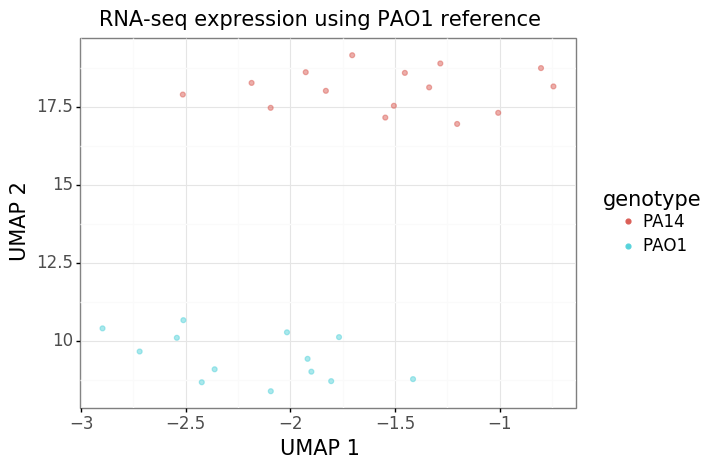

<ggplot: (8772129310557)>


In [21]:
# Plot PAO1
fig = ggplot(pao1_encoded_df, aes(x='1', y='2'))
fig += geom_point(aes(color='genotype'), alpha=0.5)
fig += labs(x ='UMAP 1',
            y = 'UMAP 2',
            title = 'RNA-seq expression using PAO1 reference')
fig += theme_bw()
fig += theme(
    legend_title_align = "center",
    plot_background=element_rect(fill='white'),
    legend_key=element_rect(fill='white', colour='white'), 
    legend_title=element_text(family='sans-serif', size=15),
    legend_text=element_text(family='sans-serif', size=12),
    plot_title=element_text(family='sans-serif', size=15),
    axis_text=element_text(family='sans-serif', size=12),
    axis_title=element_text(family='sans-serif', size=15)
    )
fig += guides(colour=guide_legend(override_aes={'alpha': 1}))

print(fig)

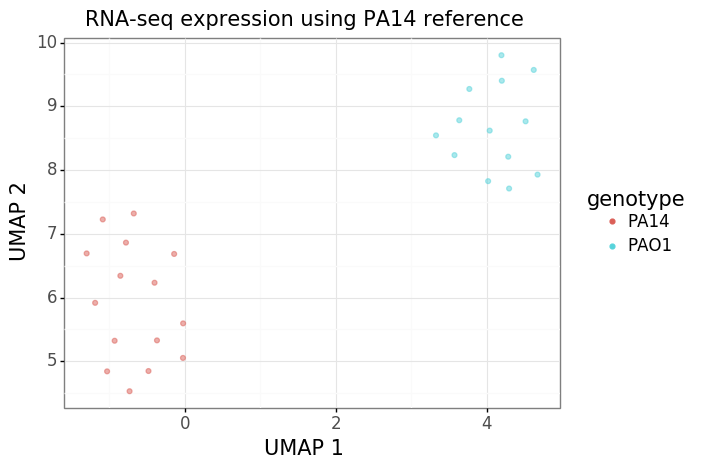

<ggplot: (8772129352817)>


In [22]:
# Plot PA14
fig = ggplot(pa14_encoded_df, aes(x='1', y='2'))
fig += geom_point(aes(color='genotype'), alpha=0.5)
fig += labs(x ='UMAP 1',
            y = 'UMAP 2',
            title = 'RNA-seq expression using PA14 reference')
fig += theme_bw()
fig += theme(
    legend_title_align = "center",
    plot_background=element_rect(fill='white'),
    legend_key=element_rect(fill='white', colour='white'), 
    legend_title=element_text(family='sans-serif', size=15),
    legend_text=element_text(family='sans-serif', size=12),
    plot_title=element_text(family='sans-serif', size=15),
    axis_text=element_text(family='sans-serif', size=12),
    axis_title=element_text(family='sans-serif', size=15)
    )
fig += guides(colour=guide_legend(override_aes={'alpha': 1}))

print(fig)